# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [57]:
# import libraries
import pandas as pd
import nltk
import re
import sklearn as sk
import math

import pickle

from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [2]:
nltk.download(["punkt", "wordnet"])

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table("MessageData", engine)
df.head()
X = df.message
Y = df.loc[:, "related":"direct_report"]

In [8]:
# Visualizations
df.head()


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


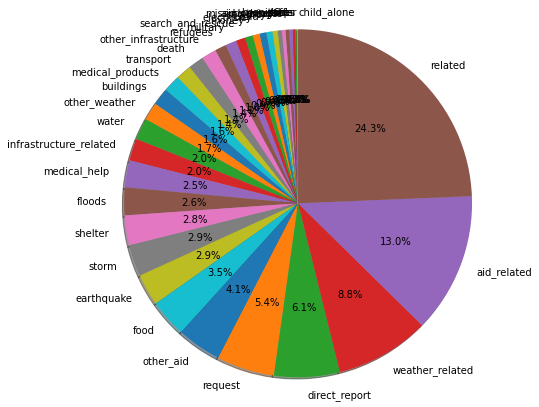

In [37]:
cat_number=df.loc[:, "related":"direct_report"].sum(axis=0).reset_index()
cat_number.columns=["category", "count"]
cat_number=cat_number.sort_values(by="count")

fig1, ax1 = plt.subplots()
ax1.pie(cat_number["count"], labels=cat_number["category"], autopct='%1.1f%%',
        shadow=True, radius=2, startangle=90)
plt.show()

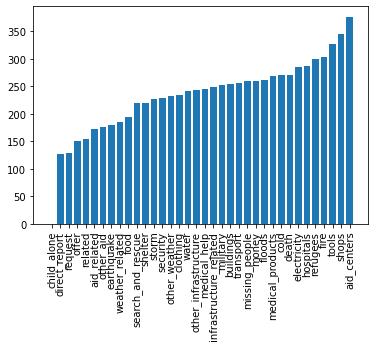

In [63]:
#letter_count=df.message.str.len()

df["letter_count"]=df.message.str.len()

cat_strlen_l=[]
categories=df.loc[:, "related":"direct_report"].columns
for cat in categories:
    avg_strlen=df[df[cat]==1].letter_count.mean()
    if(math.isnan(avg_strlen)):
        avg_strlen=0
    cat_strlen_l.append({"category": cat, "avg_strlen": avg_strlen})
cat_strlen=pd.DataFrame(cat_strlen_l)
cat_strlen=cat_strlen.sort_values("avg_strlen")

cat_strlen

fig2, ax2 = plt.subplots()
ax2.bar(x=cat_strlen.category, height=cat_strlen.avg_strlen)
plt.xticks(rotation=90)
plt.show()


### 2. Write a tokenization function to process your text data

In [29]:
def tokenize(text):
    found_urls=re.findall(url_regex, text)
    for pos in found_urls:
        text=text.replace(pos, "urlplaceholder")
    text=re.sub(r"[^a-zA-Z0-9]", " ", text) 
    text=text.lower()
    words=nltk.word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for w in words:
        tok=lemmatizer.lemmatize(w).lower().strip()
        clean_tokens.append(tok)
        
    return clean_tokens
    

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [30]:
pipeline = Pipeline([
    ("vect", CountVectorizer(tokenizer=tokenize)),
    ("tfidf", TfidfTransformer()),
    ('moclf', MultiOutputClassifier(RandomForestClassifier()))
])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [32]:
Y_pred=pd.DataFrame(pipeline.predict(X_test))
Y_pred.columns=Y_test.columns

In [56]:
Y_test=Y_test.reset_index(drop=True)
acc_avg=0
for col in Y_test.columns:    
    accuracy_col=(Y_test[col]==Y_pred[col]).mean()
    acc_avg=acc_avg+accuracy_col
    #print(col, ": ", accuracy_col)
print("Avg. accuracy: ", acc_avg/len(Y_test.columns))    

Avg. accuracy:  0.942032368503


In [47]:
for col in Y_test.columns:
    print(col)
    report=classification_report(Y_test[col], Y_pred[col])
    print(report)

related
             precision    recall  f1-score   support

          0       0.62      0.35      0.45      1869
          1       0.81      0.93      0.87      5926
          2       0.83      0.17      0.28        59

avg / total       0.77      0.79      0.77      7854

request
             precision    recall  f1-score   support

          0       0.88      0.98      0.93      6512
          1       0.83      0.37      0.51      1342

avg / total       0.87      0.88      0.86      7854

offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7816
          1       0.00      0.00      0.00        38

avg / total       0.99      1.00      0.99      7854

aid_related
             precision    recall  f1-score   support

          0       0.72      0.88      0.79      4612
          1       0.75      0.52      0.61      3242

avg / total       0.73      0.73      0.72      7854

medical_help
             precision    recall  f1-sco

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
'''for col in Y_test.columns:
    print(col)
    print(precision_recall_fscore_support(Y_test[col], Y_pred[col]))
    '''

'for col in Y_test.columns:\n    print(col)\n    print(precision_recall_fscore_support(Y_test[col], Y_pred[col]))\n    '

In [49]:
'''Y_pred.water.value_counts()
print(sk.__version__)'''
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x7f788d029d08>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('moclf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=Non

### 6. Improve your model
Use grid search to find better parameters. 

In [50]:
parameters = {
    "moclf__estimator__criterion": ["gini", "entropy"],
    "moclf__estimator__max_depth": [5, 10, None]    
}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, Y_train)

Y_pred_gs=pd.DataFrame(cv.predict(X_test))

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [53]:
Y_pred_gs.columns=Y_test.columns

In [54]:
for col in Y_test.columns:
    print(col)
    report=classification_report(Y_test[col], Y_pred_gs[col])
    print(report)

related
             precision    recall  f1-score   support

          0       0.63      0.37      0.47      1869
          1       0.82      0.93      0.87      5926
          2       0.69      0.19      0.29        59

avg / total       0.77      0.79      0.77      7854

request
             precision    recall  f1-score   support

          0       0.88      0.99      0.93      6512
          1       0.84      0.36      0.51      1342

avg / total       0.88      0.88      0.86      7854

offer
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7816
          1       0.00      0.00      0.00        38

avg / total       0.99      1.00      0.99      7854

aid_related
             precision    recall  f1-score   support

          0       0.72      0.88      0.79      4612
          1       0.75      0.52      0.62      3242

avg / total       0.74      0.73      0.72      7854

medical_help
             precision    recall  f1-sco

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
Y_test=Y_test.reset_index(drop=True)
acc_avg_gs=0
for col in Y_test.columns:    
    accuracy_col_gs=(Y_test[col]==Y_pred_gs[col]).mean()
    acc_avg_gs=acc_avg_gs+accuracy_col_gs
    #print(col, ": ", accuracy_col_gs)
print("Avg. accuracy: ", acc_avg_gs/len(Y_test.columns))  

Avg. accuracy:  0.942478001302


In [58]:
print(cv.best_params_)

{'moclf__estimator__criterion': 'gini', 'moclf__estimator__max_depth': None}


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [63]:
'''file = open("pickled_model.p", "wb")
s = pickle.dump(cv, file)
file.close()'''

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.